In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from collections import defaultdict
import sklearn
from sklearn.linear_model import LinearRegression
sns.set_style('whitegrid')
from scipy.signal import lfiltic, lfilter
import wandb
import pandas as pd 
# careful not to mix between scipy.signal and standard python signal 
# (https://docs.python.org/3/library/signal.html) if your code handles some processes
font = {'family' : 'normal',
        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)


In [ ]:
def pull_data():
    api = wandb.Api()
    entity, project = "pierthodo", "RTDM_performance"  # set to your entity and project 
    runs = api.runs(entity + "/" + project) 
    summary_list = []
    config_list = []
    data = []
    for idx,run in enumerate(runs): 
        print(idx)
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)
        data.append(pd.DataFrame([i for i in run.scan_history()]))
        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
             if not k.startswith('_')})

    pickle.dump((config_list,data),open("repeat.pkl","wb"))
    api = wandb.Api()
    entity, project = "pierthodo", "RTDM_train"  # set to your entity and project 
    runs = api.runs(entity + "/" + project) 

    summary_list = []
    config_list = []
    data = []
    for idx,run in enumerate(runs): 
        print(idx)
        config_list.append(
            {k: v for k,v in run.config.items()
             if not k.startswith('_')})
        print(config_list[-1])
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        data.append(pd.DataFrame([i for i in run.history(keys=["reward"])]))
        # .config contains the hyperparameters.
        #  We remove special values that start with _.

    pickle.dump((config_list,data),open("train.pkl","wb"))

In [ ]:
def load_repeat(mean=True):
    data_repeat = pickle.load(open("repeat.pkl","rb"))
    config_list, data = data_repeat
    d_repeat = defaultdict(list)
    for i in range(len(config_list)):
        try:
            d_repeat[config_list[i]["env"]+"_"+config_list[i]["algorithm"]].append(data[i])
        except:
            print("Error on ",i)
    new_dic = {}
    for i in d_repeat.keys():
        try:
            tmp = np.array([n["Reward"] for n in d_repeat[i]]).mean(axis=0)
            new_dic[i]= d_repeat[i][0]
            new_dic[i]["Reward"] = tmp
        except:
            continue
    return new_dic
def filter_dic(dic):
    dic_filter = []
    for i in dic:
        if bool(i):
            dic_filter.append(i)
    return dic_filter

def ewma_linear_filter(array, window):
    alpha = 2 /(window + 1)
    b = [alpha]
    a = [1, alpha-1]
    zi = lfiltic(b, a, array[0:1], [0])
    return lfilter(b, a, array, zi=zi)[0]

In [3]:
inf_time_dreamer = {"walker_walk_gpu_0":0.033,"walker_walk_gpu_1":0.003659}
dt_dic = {"Hopper-v2":0.002, "HalfCheetah-v2":0.01,"continuous_CartPole-v0":0.02,"Humanoid-v2":0.003,"Pusher-v2":0.01,
         "dmc_walker_walk":0.0025,"dmc_cheetah_run":0.01,"dmc_cartpole_balance":0.01}
inference_time = pickle.load(open("inference_time.pkl","rb"))
data_repeat = load_repeat()
env_list = dt_dic.keys()
algo_list = ["sac","ppo","ars","mbpo","rtrl"] #"pets",

Inference time plot

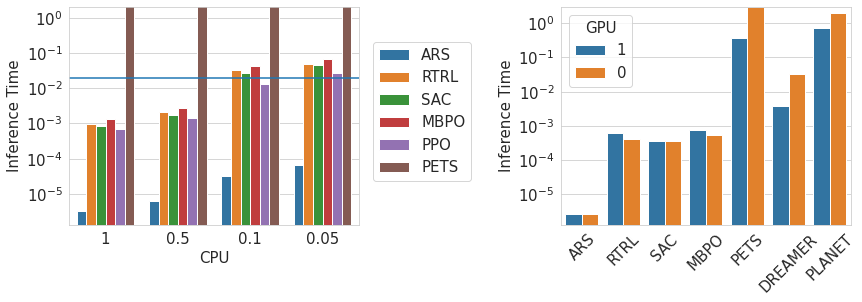

In [563]:
def inference_time_pandas(inference_time,env_list):
    columns = ["Algo","Env","GPU","CPU","Inference Time"]
    data = []
    for env_name in env_list:
        for k,v in inference_time.items():
            tmp = k.split("_")
            algorithm = k.split("_")[2]
            cpu = k.split("_")[1]
            if "continuous" in k:
                env = "continuous_CartPole-v0"
                gpu = k.split("_")[6]
            elif "dmc" in k:
                env = k.split("_")[3] + "_" +k.split("_")[4] + "_" +k.split("_")[5]
                gpu = k.split("_")[7]
            else:
                env = k.split("_")[3]
                gpu = k.split("_")[5]
            if float(cpu) in [1,0.5,0.1,0.05] and int(gpu) == 0 and env == env_name:
                for i in v:
                    data.append([algorithm,env,gpu,cpu,i])
    df = pd.DataFrame(data,columns=columns)
    df["Algo"]= df["Algo"].apply(lambda s: s.upper())
    return df
    

fig, ax_list = plt.subplots(1, 2,figsize=(14,4))
ax = ax_list[0]
df = inference_time_pandas(inference_time,env_list)
sns.barplot(x="CPU",y="Inference Time",hue="Algo",data=df,ax=ax,ci=None)
if idx != 2:
    ax.legend([],[], frameon=False)
ax.set_yscale("log")
ax.set_ylim(top=2)
ax.axhline(y=dt_dic[env_name])
ax.legend(loc=(1.05,0.2))

#ax.title(env_name)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=None)


def inference_time_pandas(inference_time,env_name):
    columns = ["Algo","Env","GPU","CPU","Inference Time"]
    data = []
    for k,v in inference_time.items():
        tmp = k.split("_")
        algorithm = k.split("_")[2]
        cpu = k.split("_")[1]
        if "continuous" in k:
            env = "continuous_CartPole-v0"
            gpu = k.split("_")[6]
        elif "dmc" in k:
            env = k.split("_")[3] + "_" +k.split("_")[4] + "_" +k.split("_")[5]
            gpu = k.split("_")[7]
        else:
            env = k.split("_")[3]
            gpu = k.split("_")[5]
        if float(cpu) in [4]:
            for i in v:
                data.append([algorithm,env,gpu,cpu,i])
    df = pd.DataFrame(data,columns=columns)
    df["Algo"]= df["Algo"].apply(lambda s: s.upper())
    return df

order = ["ARS","RTRL","SAC","MBPO","PETS","DREAMER","PLANET"]
df = inference_time_pandas(inference_time,env_name)
sns.barplot(x="Algo",y="Inference Time",hue="GPU",data=df,ci=None,ax=ax_list[1],order=order)
ax_list[1].set_yscale("log")
ax_list[1].set_xlabel("")
ax_list[1].set_ylim(top=3)
plt.xticks(rotation=45)

plt.savefig("inference_time.pdf", bbox_inches="tight")

Plot perf repeat

/var/folders/gh/p4yzpxj12kb1y1br706pl5800000gp/T/ipykernel_39388/4078399707.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/var/folders/gh/p4yzpxj12kb1y1br706pl5800000gp/T/ipykernel_39388/4078399707.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


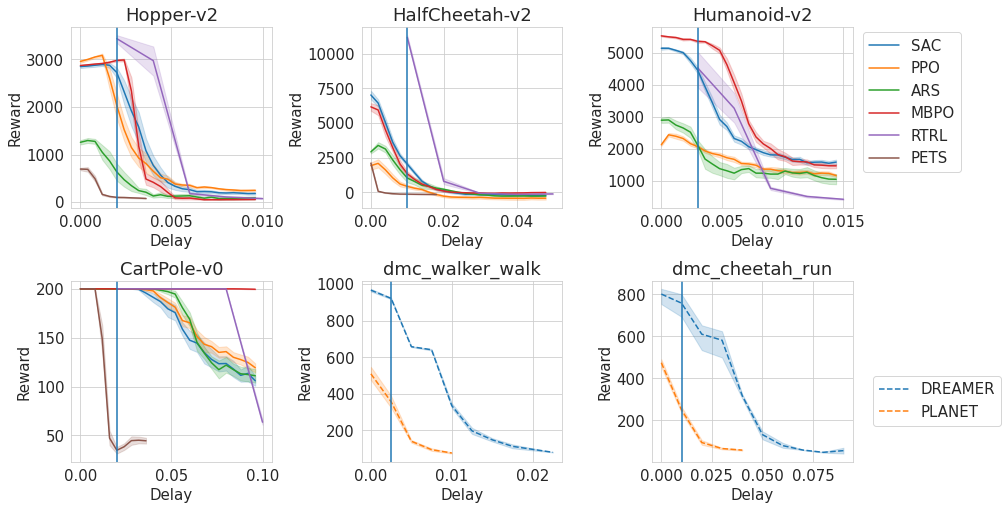

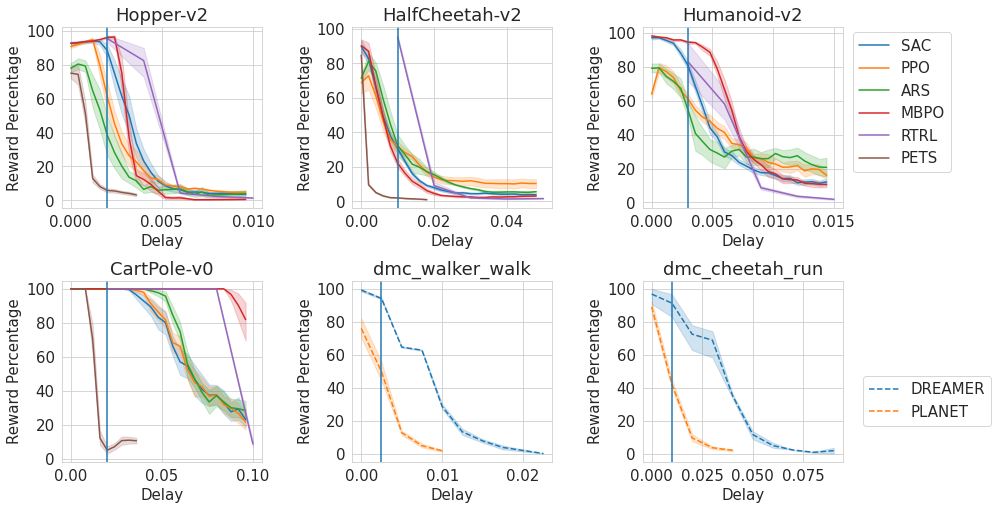

In [697]:
algo_list_t = ["sac","ppo","ars","mbpo","rtrl"] #"pets",
for plot_type in ["Reward","Reward Percentage"]:
    config,repeat_data = pickle.load(open("repeat.pkl","rb"))
    fig, ax_list = plt.subplots(2, 3,figsize=(14,8))
    ax_list = ax_list.flatten()
    for idx,env_name in enumerate(["Hopper-v2","HalfCheetah-v2","Humanoid-v2","continuous_CartPole-v0","dmc_walker_walk","dmc_cheetah_run"]):
        data = []
        for i in range(len(config)):
            try: # This section is used to format the data into a pandas dataframe 
                if config[i]["env"] == env_name :
                    repeat_data[i]["Algo"] = config[i]["algorithm"]
                    repeat_data[i]["Env"] = config[i]["env"]
                    tmp = repeat_data[i]
                    if config[i]["algorithm"] == "rtrl": # if the algorithm is rtrl you need to adjust the number of step you use
                        tmp["_step"] = tmp["_step"] * 5 + 5
                        data.append(tmp[:5])
                    else:
                        data.append(tmp[:25])
            except:
                continue

        df = pd.concat(data)
        df = df.reset_index()
        df = df.drop(columns="index")
        df["Reward Percentage"] = "NaN"
        alg_list = pd.unique(df["Algo"].values.ravel()) # Get the list of algorithm
        tmp_list = ["dreamer","planet"]if idx > 4 else alg_list 
        for algo in tmp_list:
            try:
                tmp = df[(df["Algo"]==algo) ]["Reward"]
                max_r = np.max(tmp)
                min_r = np.min(tmp)
            except:
                print(df[(df["Algo"]==algo) ])
            df.loc[df["Algo"]==algo, "Reward Percentage"]= 100*(1-((max_r -df[(df["Algo"]==algo) ]["Reward"])/(max_r-min_r)))

        disc = 1 if idx > 3 else 5
        df["Delay"] = df["_step"]*(dt_dic[env_name]/disc)

        df["Algo"]= df["Algo"].apply(lambda s: s.upper())
        tmp_algo_list = [i.upper() for i in algo_list]
        if idx >3:
            sns.lineplot(data=df,x="Delay",y=plot_type,hue="Algo",ax=ax_list[idx], linestyle='--').set_title(env_name)            
        else:
            if env_name == "Humanoid-v2":
                sns.lineplot(data=df,x="Delay",y=plot_type,hue="Algo",ax=ax_list[idx],hue_order=tmp_algo_list).set_title(env_name)
            else:
                if "continuous" in env_name:
                    sns.lineplot(data=df,x="Delay",y=plot_type,hue="Algo",ax=ax_list[idx],hue_order=tmp_algo_list+["PETS"]).set_title("CartPole-v0")
                else:
                    sns.lineplot(data=df,x="Delay",y=plot_type,hue="Algo",ax=ax_list[idx],hue_order=tmp_algo_list+["PETS"]).set_title(env_name)
        if idx == 0:
            ax_list[idx].legend(loc=(3.95,0.2))
        elif idx == 5:
            h = plt.gca().get_lines()
            ax_list[idx].legend(handles=h, labels=["DREAMER","PLANET"], loc=(1.1,0.2))
        else:
            ax_list[idx].legend([],[], frameon=False)
        ax_list[idx].axvline(x=dt_dic[env_name])

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.45, hspace=0.4)
    plt.tight_layout()
    plt.savefig(plot_type+"_repeat.pdf", bbox_inches="tight")
    

Plot performance

/var/folders/gh/p4yzpxj12kb1y1br706pl5800000gp/T/ipykernel_39388/4053832073.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop("index",1)
/var/folders/gh/p4yzpxj12kb1y1br706pl5800000gp/T/ipykernel_39388/4053832073.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop("index",1)
/var/folders/gh/p4yzpxj12kb1y1br706pl5800000gp/T/ipykernel_39388/4053832073.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop("index",1)
/var/folders/gh/p4yzpxj12kb1y1br706pl5800000gp/T/ipykernel_39388/4053832073.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop("index",1)
/var/folders/gh/p4yzpxj12kb1y1br706pl580

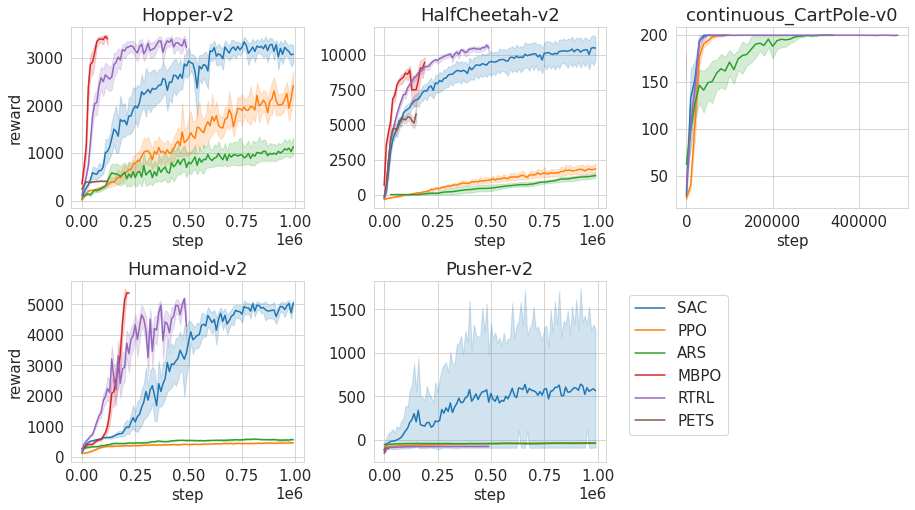

In [580]:
fig=plt.figure(figsize=(15,8))
columns = 3
rows = 2

for idx,env_name in enumerate(env_list):
    ax = fig.add_subplot(rows, columns,1+ idx)
    data = []
    for f in os.listdir("./results_train"):
        if env_name in f:
            d = pickle.load(open("./results_train/"+f,"rb"))
            df = pd.DataFrame(d["data"])
            df = df[df["step"] < 1000000]
            df["Algo"] = d["algo"]
            df["env"] = d["env"]
            df["seed"] = d["seed"]
            #if d["algo"] == "ARS":
            df["step"] = ((df["step"]/10000).astype(int))*10000
            data.append(df)
    df = pd.concat(data)
    df = df.reset_index()
    df = df.drop("index",1)
    #df['10reward'] = df['reward'].ewm(span=10, adjust=False).mean()
    sns.lineplot(data=df,x="step",y="reward",hue="Algo",ax=ax,hue_order=tmp_algo_list+["PETS"])
    if idx != 4:
        ax.legend([],[], frameon=False)
    else:
        ax.legend(loc=(1.1,0.15))
    if idx not in [0,3]:
        ax.set_ylabel("")
    #if idx in [0,1,2]:
    ##    ax.set_xlabel("")
    plt.title(env_name)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3,hspace=0.4)    
plt.savefig("performance.pdf", bbox_inches="tight")


Plot adjusted performance

Error on  80
Error on  106


/var/folders/gh/p4yzpxj12kb1y1br706pl5800000gp/T/ipykernel_1216/3417195130.py:42: RuntimeWarning: invalid value encountered in true_divide
  p_list = 100*(1-((r_list[-1]-r_list)/(np.max(r_list)-np.min(r_list))))
/var/folders/gh/p4yzpxj12kb1y1br706pl5800000gp/T/ipykernel_1216/3417195130.py:70: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


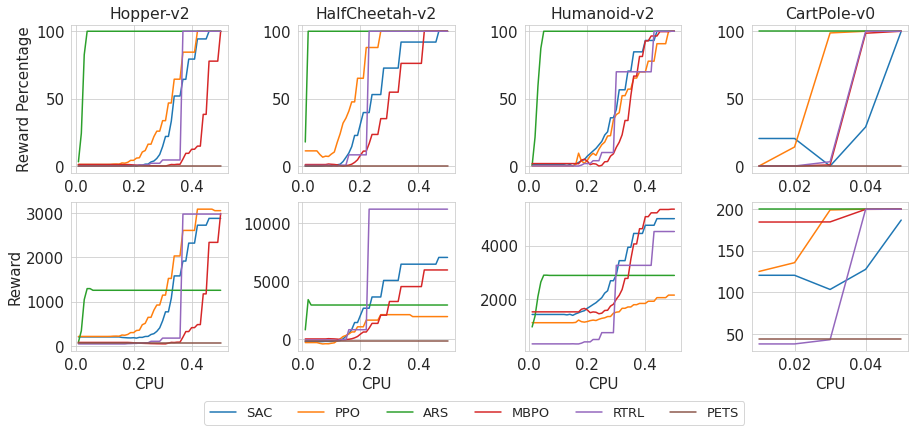

In [24]:
font = {'family' : 'normal',
        'size'   : 13}
make_s = lambda algo,env,gpu,cpu_num: "cpu_"+str(cpu_num)+"_"+algo+"_"+env+"_gpu_"+str(gpu)
#config,repeat_data = filter_dic(pickle.load(open("repeat.pkl","rb")))
data_repeat = load_repeat()
import matplotlib
_,ax_list = plt.subplots(2,4,figsize=(15,6))
#ax_list = ax_list.flatten()

matplotlib.rc('font', **font)
for idx_c,plot_content in enumerate(["Reward Percentage","Reward"]):

    for idx,env in enumerate(["Hopper-v2","HalfCheetah-v2","Humanoid-v2","continuous_CartPole-v0"]):
        if "continuous" in env:
            cpu_num = 0.05
        else:
            cpu_num = 0.5
        calc = lambda x,cpu_time: [cpu_time * (cpu_num/i)**2 for i in x]
        pd_data = []
        for algo in algo_list+["pets"]:
            if env == "Humanoid-v2" and algo == "pets":
                continue

            r_list = []
            #if algo == "mbpo" or algo == "rtrl":
            #    cpu_time = np.median(inference_time[make_s("sac",env,0,cpu_num)])
            #else:
            cpu_time = np.median(inference_time[make_s(algo,env,0,cpu_num)])

            x_t = [i*0.01 + 0.01 for i in range(int(cpu_num*100))]
            t = calc(x_t,cpu_time)
            for inf_time in t:
                if algo in ["rtrl","pets"]:
                    dt = dt_dic[env]
                else:
                    dt = dt_dic[env]/5
                repeat = int(inf_time/dt)
                repeat = 49 if repeat > 49 else repeat
                if algo in ["rtrl","pets"]:
                    repeat = 9 if repeat > 9 else repeat
                r_list.append(data_repeat[env+"_"+algo].iloc[repeat]["Reward"])
            p_list = 100*(1-((r_list[-1]-r_list)/(np.max(r_list)-np.min(r_list))))
            p_list = [100 if i > 100 else i for i in p_list]
            if algo == "ars" and env == "continuous_CartPole-v0":
                p_list = [100]*len(r_list)
            if algo == "pets":
                p_list = [0]*len(r_list)
            if plot_content == "Reward Percentage":
                ax_list[idx_c,idx].plot(x_t,p_list,label=algo.upper())
            else:
                ax_list[idx_c,idx].plot(x_t,r_list,label=algo.upper())
        if idx_c == 0:
            if "continuous" in env:
                ax_list[idx_c,idx].set_title("CartPole-v0")
            else:
                ax_list[idx_c,idx].set_title(env)
        else:
            ax_list[idx_c,idx].set_xlabel("CPU")
        ax_list[idx_c,idx].set_ylabel(plot_content)
        if idx == 0 and idx_c==1:
            ax_list[idx_c,idx].legend(loc=(0.85,-0.5), ncol=6)
        if idx != 0:
            ax_list[idx_c,idx].set_ylabel("")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.45, hspace=None)
plt.tight_layout()
plt.savefig("performance_adjusted.pdf", bbox_inches="tight")
font = {'family' : 'normal',
        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)